In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [98]:
# customers table check
# this table holds demographic information and is at a CUSTOMER level
# it has 10,000 entries, as we have 10,000 customers
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [99]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [100]:
# engagement table check
# this table holds aggregate CUSTOMER level data on the number of site visits, emails opened and clicks
# it also has 10,000 rows, one for each customer
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [101]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [102]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [103]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [104]:
# transaction data check
# this table is at a TRANSACTION ID level, and has 129,545 rows, meaning each customer has multiple transactions
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [105]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


### Combine the tables: Join at Lowest Common Denominator (transaction level)

This option is a bit more tricky because we need to join at a customer ID, but also map the dates between the marketing campaign and subsequent purchase. We would want to see which marketing campaign was sent to the user before they made a transaction.

In [106]:
# step 1: make transactions and marketing indexes as customer_id for easy joining
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)
transactions.set_index('customer_id', inplace=True)
marketing.set_index('customer_id', inplace=True)

In [107]:
# now we CANNOT join the full data directly because this will result in DUPLICATES
# DON'T do this > I'm just demonstrating what will happen - you can see below an example of user 1
customers.join(engagement).join(marketing).join(transactions).loc[1]

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,campaign_id,response,promotion_type,campaign_date,transaction_id,transaction_date,transaction_amount,product_category
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,1,2024-02-03,165.56,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,2,2024-03-02,699.01,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,3,2024-03-12,146.86,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,4,2024-01-20,927.46,Electronics
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,5,2024-02-25,1395.87,Electronics
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,No,Buy One Get One,2024-02-29,6,2024-01-09,174.72,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,No,Discount,2024-01-24,1,2024-02-03,165.56,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,No,Discount,2024-01-24,2,2024-03-02,699.01,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,No,Discount,2024-01-24,3,2024-03-12,146.86,Home Goods


In [108]:
# instead; for the transactions and marketing tables, we need to align the marketing campaign dates with the transactions
# in other words > which marketing campaign was the user exposed to before they made a transaction?
# and did they respond positively or negatively to that?
# we need to convert key dates to datetime objects

marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [109]:
# now we can use the merge() function in combination with the joins
# join the first 3 tables

transaction_level = customers.join(engagement).join(transactions)

In [110]:
# reset index
transaction_level.reset_index(inplace=True)

In [111]:
# reset index
marketing.reset_index(inplace=True)

In [112]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [113]:
# make sure sorting is correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [114]:
# make sure data type is correct
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [115]:
# make sure sorting is correct
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [116]:
# make sure date datatype is correct
marketing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25200 entries, 3 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     25200 non-null  int64         
 1   campaign_id     25200 non-null  int64         
 2   response        25200 non-null  object        
 3   promotion_type  25200 non-null  object        
 4   campaign_date   25200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.2+ MB


In [117]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [118]:
# merge dataframe and check customer # 1
# we can see for each transaction, now we can see if there was a marketing campaign sent to the customer before they made the transaction, and whether they responded Yes or No
# if there was NOT a marketing campaign sent to them before they made the transaction, we get missing values > hint: don't impute these.
df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [119]:
# double check marketing aligns
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [120]:
# double check transactions are correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [121]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [122]:
# 获取唯一值
unique_customer_ids = df_merged['campaign_customer_id'].unique()

# 检查是否存在值0
has_zero = 0 in unique_customer_ids

print(f"Unique customer IDs: {unique_customer_ids}")
print(f"Does campaign_customer_id contain 0? {has_zero}")

Unique customer IDs: [      nan 1.000e+00 2.000e+00 ... 9.998e+03 9.999e+03 1.000e+04]
Does campaign_customer_id contain 0? False


In [123]:
# 获取唯一值
unique_campaign_ids = df_merged['campaign_campaign_id'].unique()

# 检查是否存在值0
has_zero = 0 in unique_campaign_ids

print(f"Unique campaign IDs: {unique_campaign_ids}")
print(f"Does campaign_campaign_id contain 0? {has_zero}")


Unique campaign IDs: [       nan 4.0000e+00 2.0000e+00 ... 2.5198e+04 2.5197e+04 2.5200e+04]
Does campaign_campaign_id contain 0? False


In [124]:
df_merged['campaign_response'].unique()

array([None, 'Yes', 'No'], dtype=object)

In [125]:
df_merged['campaign_campaign_date'].unique()

<DatetimeArray>
[                'NaT', '2024-01-10 00:00:00', '2024-01-24 00:00:00',
 '2024-02-29 00:00:00', '2024-03-05 00:00:00', '2021-11-12 00:00:00',
 '2022-07-08 00:00:00', '2021-11-15 00:00:00', '2022-08-11 00:00:00',
 '2022-03-02 00:00:00',
 ...
 '2020-04-17 00:00:00', '2020-02-10 00:00:00', '2020-02-15 00:00:00',
 '2020-02-11 00:00:00', '2020-03-03 00:00:00', '2020-05-04 00:00:00',
 '2020-03-09 00:00:00', '2020-04-02 00:00:00', '2020-02-22 00:00:00',
 '2020-05-16 00:00:00']
Length: 1588, dtype: datetime64[ns]

In [126]:
# check missing value
missing_values = df_merged.isnull().sum()
print(missing_values)

customer_id                    0
join_date                      0
last_purchase_date             0
age                        13082
gender                      7020
location                       0
number_of_site_visits          0
number_of_emails_opened        0
number_of_clicks               0
transaction_id                 0
transaction_date               0
transaction_amount             0
product_category               0
campaign_customer_id       39556
campaign_campaign_id       39556
campaign_response          39556
campaign_promotion_type    39556
campaign_campaign_date     39556
dtype: int64


In [127]:
# 填充缺失值为特定值
df_merged['age'].fillna(df_merged['age'].median(), inplace=True)
df_merged['gender'].fillna('Prefer not to say', inplace=True)
df_merged['campaign_customer_id'].fillna(0.0, inplace=True)
df_merged['campaign_campaign_id'].fillna(0.0, inplace=True)
df_merged['campaign_response'].fillna('Not Available', inplace=True)
df_merged['campaign_promotion_type'].fillna('Not Available', inplace=True)
df_merged['campaign_campaign_date'].fillna('Not Available', inplace=True)

# 检查填充后的缺失值情况
missing_values_after = df_merged.isnull().sum()
print(missing_values_after)

/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_5085/691565099.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['age'].fillna(df_merged['age'].median(), inplace=True)
/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_5085/691565099.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

customer_id                0
join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_date           0
transaction_amount         0
product_category           0
campaign_customer_id       0
campaign_campaign_id       0
campaign_response          0
campaign_promotion_type    0
campaign_campaign_date     0
dtype: int64


In [128]:
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [129]:
transaction_level.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods


In [130]:
transaction_level.describe()

,customer_id,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount
count,129545.000000,116463.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545,129545.000000
mean,4998.806237,43.576295,99.471218,39.685291,19.569362,64773.000000,2022-10-04 21:22:51.998919168,597.287659
min,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,2020-01-06 00:00:00,10.020000
25%,2494.000000,30.000000,15.000000,6.000000,3.000000,32387.000000,2021-12-06 00:00:00,228.320000
50%,5006.000000,44.000000,53.000000,22.000000,11.000000,64773.000000,2022-11-29 00:00:00,438.380000
75%,7476.000000,57.000000,140.000000,57.000000,28.000000,97159.000000,2023-09-18 00:00:00,846.980000
max,10000.000000,69.000000,711.000000,303.000000,142.000000,129545.000000,2024-05-31 00:00:00,1999.990000
std,2882.049926,15.088298,117.840580,46.423741,22.749093,37396.564648,NaN,491.564174


In [131]:
# check missing value
missing_values = transaction_level.isnull().sum()
print(missing_values)

customer_id                    0
join_date                      0
last_purchase_date             0
age                        13082
gender                      7020
location                       0
number_of_site_visits          0
number_of_emails_opened        0
number_of_clicks               0
transaction_id                 0
transaction_date               0
transaction_amount             0
product_category               0
dtype: int64


In [132]:
transaction_level['age'].fillna(method='ffill', inplace=True)

/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_5085/624844921.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transaction_level['age'].fillna(method='ffill', inplace=True)
/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_5085/624844921.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  transaction_level['age'].fillna(method='ffill', inplace=True)


In [133]:
# Fill missing age values ​​with the median
# transaction_level['age'].fillna(transaction_level['age'].median(), inplace=True)

# Use 'Prefer not to say' replace missing value
transaction_level['gender'].fillna('Prefer not to say', inplace=True)


/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_5085/387191856.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transaction_level['gender'].fillna('Prefer not to say', inplace=True)


In [134]:
# check missing value
missing_values = transaction_level.isnull().sum()
print(missing_values)

customer_id                0
join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_date           0
transaction_amount         0
product_category           0
dtype: int64


In [135]:
transaction_level.describe()

,customer_id,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount
count,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545.000000,129545,129545.000000
mean,4998.806237,43.533938,99.471218,39.685291,19.569362,64773.000000,2022-10-04 21:22:51.998919168,597.287659
min,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,2020-01-06 00:00:00,10.020000
25%,2494.000000,30.000000,15.000000,6.000000,3.000000,32387.000000,2021-12-06 00:00:00,228.320000
50%,5006.000000,43.000000,53.000000,22.000000,11.000000,64773.000000,2022-11-29 00:00:00,438.380000
75%,7476.000000,57.000000,140.000000,57.000000,28.000000,97159.000000,2023-09-18 00:00:00,846.980000
max,10000.000000,69.000000,711.000000,303.000000,142.000000,129545.000000,2024-05-31 00:00:00,1999.990000
std,2882.049926,15.094100,117.840580,46.423741,22.749093,37396.564648,NaN,491.564174


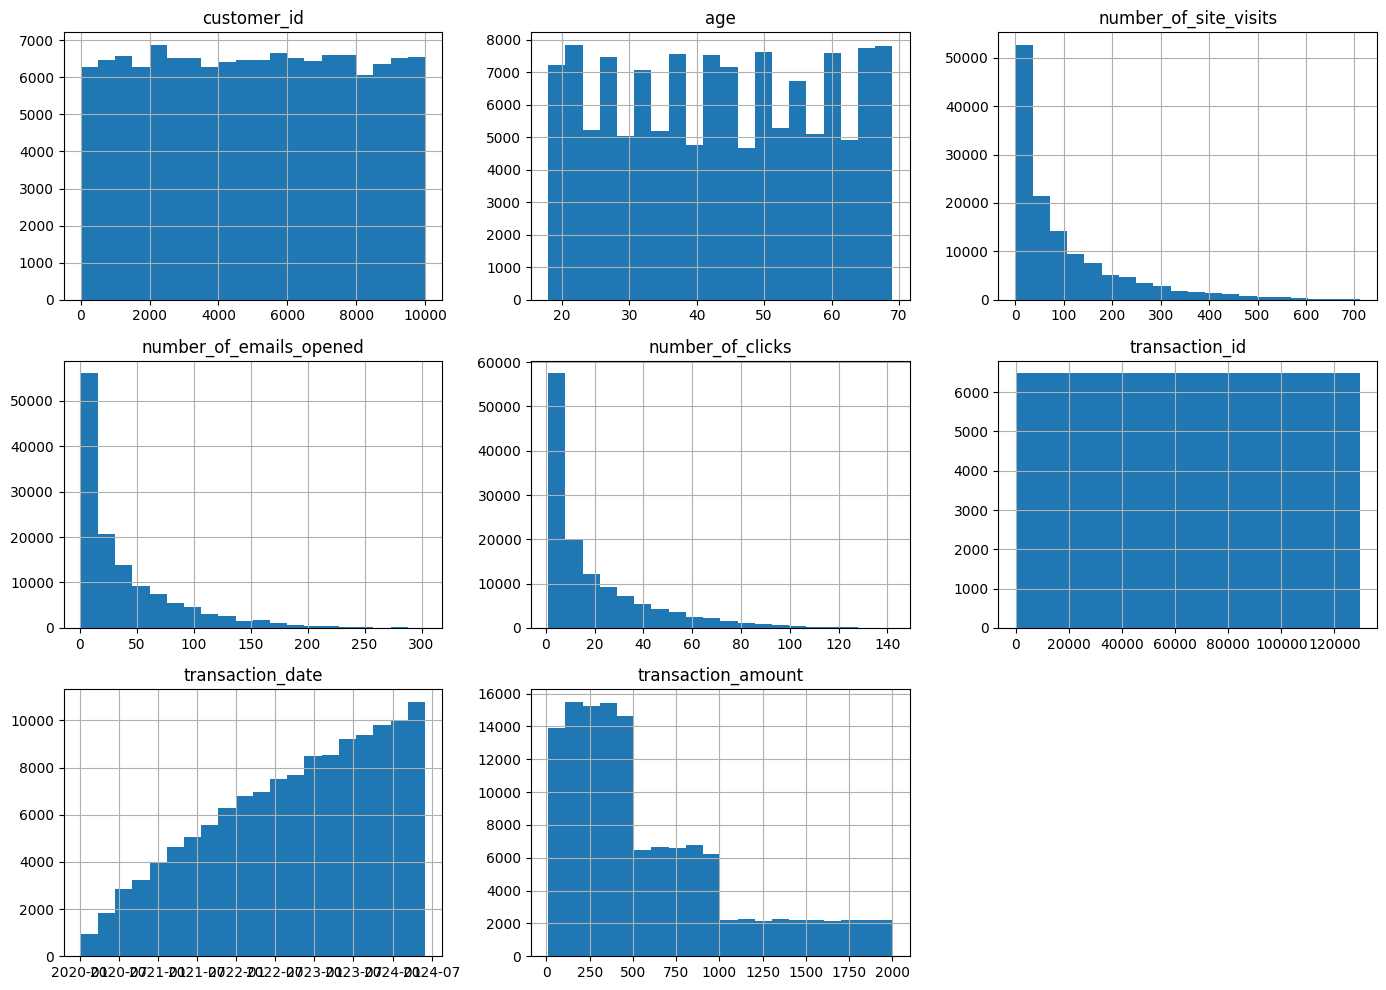

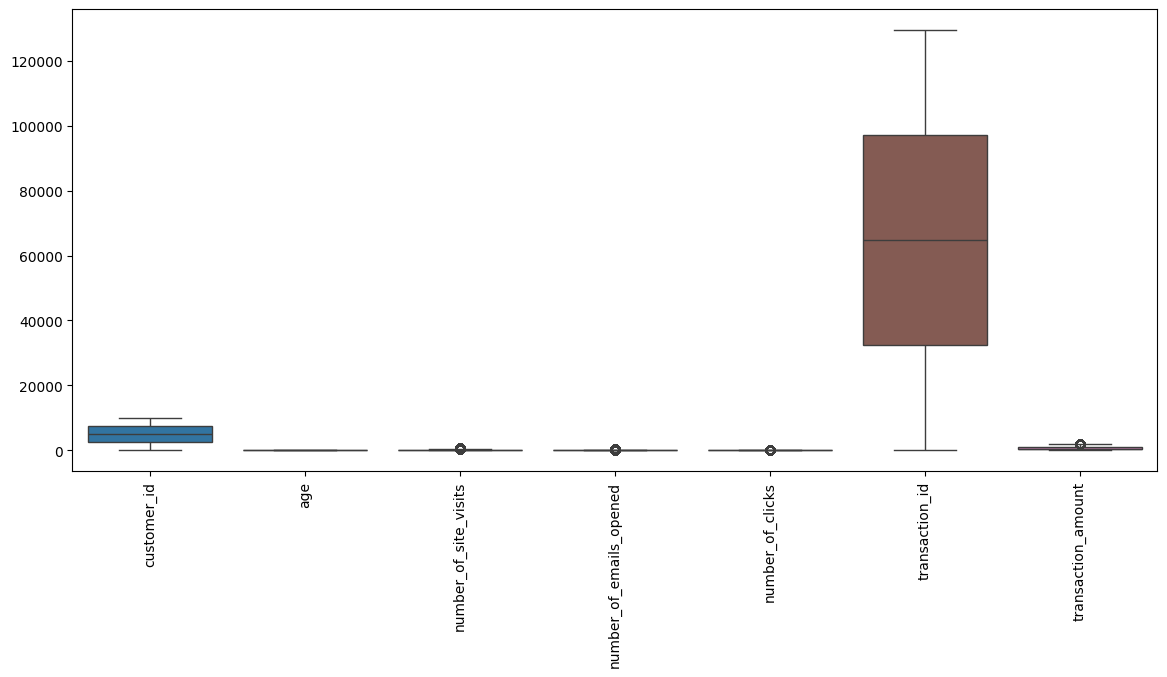

In [136]:
# histogram
transaction_level.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

# boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=transaction_level)
plt.xticks(rotation=90)
plt.show()

In [137]:
# View the distribution of categorical variables
print(transaction_level['gender'].value_counts())
print(transaction_level['location'].value_counts())


gender
Male                 61534
Female               60991
Prefer not to say     7020
Name: count, dtype: int64
location
Lake James         239
Port John          194
West David         169
South John         152
New Christopher    151
                  ... 
Hughesview           1
Amandashire          1
Hansonmouth          1
Castroborough        1
New Tylerton         1
Name: count, Length: 7695, dtype: int64


/var/folders/dt/wzt2_nrs77vgrsp6wgvfx7d00000gn/T/ipykernel_5085/214227543.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = transaction_level.set_index('transaction_date').resample('M')['transaction_amount'].sum()


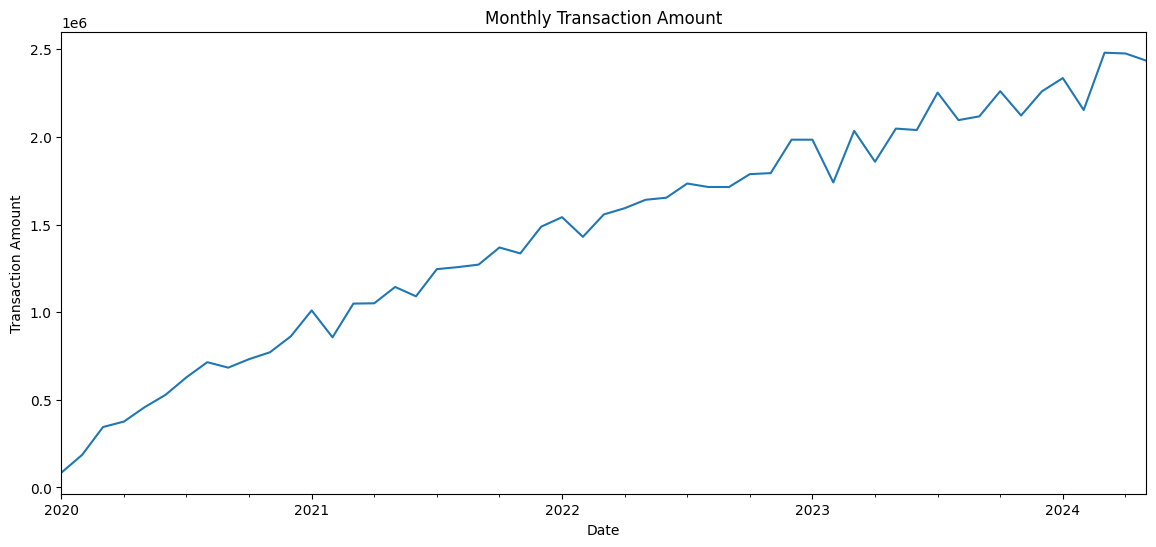

In [138]:
# 按月汇总交易金额
transaction_level['transaction_date'] = pd.to_datetime(transaction_level['transaction_date'])
monthly_sales = transaction_level.set_index('transaction_date').resample('M')['transaction_amount'].sum()

# 绘制时间序列图
plt.figure(figsize=(14, 6))
monthly_sales.plot()
plt.title('Monthly Transaction Amount')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()


### Calculating LTV
Lifetime Value is the TOTAL value the customer has brought to a company in their lifetime. This is simply a SUM of all their transactions.

Hint: you can calculate the lifetime (or age) of the customer by looking at their last transaction date vs. their join date. Be sure to use the correct data types.

In [139]:
# Calculate the total transaction amount for each customer
total_amount_per_customer = transaction_level.groupby('customer_id')['transaction_amount'].sum()

In [140]:
# Calculating customer lifecycle
first_purchase = transactions.groupby('customer_id')['transaction_date'].min()
last_purchase = transactions.groupby('customer_id')['transaction_date'].max()
customer_lifetime = (last_purchase - first_purchase).dt.days

# 计算平均购买频率
purchase_frequency = transaction_level.groupby('customer_id').size() / customer_lifetime

# 计算每次购买的平均价值
average_order_value = total_amount_per_customer / transaction_level.groupby('customer_id').size()

# 计算CLV
clv = average_order_value * purchase_frequency * customer_lifetime
clv = clv.fillna(0)  # 如果有缺失值，将其填充为0

# 合并结果
clv_df = pd.DataFrame({
    'total_amount': total_amount_per_customer,
    'customer_lifetime': customer_lifetime,
    'purchase_frequency': purchase_frequency,
    'average_order_value': average_order_value,
    'clv': clv
})

print(clv_df)

             total_amount  customer_lifetime  purchase_frequency  \
customer_id                                                        
1                 3509.48                 63            0.095238   
2                 6081.32                515            0.017476   
3                 1454.87                416            0.014423   
4                 7874.68                232            0.086207   
5                15524.55                456            0.052632   
...                   ...                ...                 ...   
9996              5498.20                161            0.062112   
9997              5848.30                146            0.082192   
9998              3503.13                 49            0.061224   
9999              6721.86                 51            0.235294   
10000             5775.83                 96            0.104167   

             average_order_value       clv  
customer_id                                 
1                     584

In [141]:
df_final = df_merged.merge(clv_df, on='customer_id', how='left')

In [142]:
clv_df.describe()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,total_amount,customer_lifetime,purchase_frequency,average_order_value,clv
count,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,7737.562981,308.464900,inf,599.842451,7641.569774
std,4628.799469,303.064036,NaN,197.350557,4700.719286
min,23.810000,0.000000,1.614205e-03,23.810000,0.000000
25%,3839.915000,64.000000,2.486188e-02,488.343409,3739.330000
50%,7498.890000,211.000000,5.579878e-02,587.587333,7417.215000
75%,11275.797500,472.000000,1.790181e-01,692.701750,11239.550000
max,24298.220000,1513.000000,inf,1997.080000,24298.220000


In [143]:
df_final.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,...,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date,total_amount,customer_lifetime,purchase_frequency,average_order_value,clv
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,...,0.0,0.0,Not Available,Not Available,Not Available,3509.48,63,0.095238,584.913333,3509.48
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,...,1.0,4.0,Yes,Buy One Get One,2024-01-10 00:00:00,3509.48,63,0.095238,584.913333,3509.48
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,...,1.0,2.0,No,Discount,2024-01-24 00:00:00,3509.48,63,0.095238,584.913333,3509.48
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,...,1.0,2.0,No,Discount,2024-01-24 00:00:00,3509.48,63,0.095238,584.913333,3509.48
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,...,1.0,1.0,No,Buy One Get One,2024-02-29 00:00:00,3509.48,63,0.095238,584.913333,3509.48


In [144]:
missing_values_after = df_final.isnull().sum()
print(missing_values_after)

customer_id                0
join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_date           0
transaction_amount         0
product_category           0
campaign_customer_id       0
campaign_campaign_id       0
campaign_response          0
campaign_promotion_type    0
campaign_campaign_date     0
total_amount               0
customer_lifetime          0
purchase_frequency         0
average_order_value        0
clv                        0
dtype: int64
